# Can a multivariate regression fit help for LHF'?

In [11]:
from sklearn import linear_model
# Some calculation for the LHF coupling and separation across spatial scales.
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import xarray as xr
import glob
import sys; sys.path.insert(1, '/home/alessandro/thesis_material/EURECA_scripts/')
import geometry as gm
import warnings; warnings.filterwarnings("ignore")
import re
from plotdistr import *
from func_statistics import *

In [2]:
# MATTE AVEVA GIA' CALCOLATO TUTTE LE CORRELAZIONI 
# E HA STIMATO QUESTA LUNGHEZZA?
L = 30
nskip = int(L/2)
nt = int(1)

# from top pbl upwards
# SOPRA PBL LA LUNGEHZZA DI CORRELAZIONE AUMENTA?
# NEL SENSO CHE I SEGNALI HANNO PIù SPAZIO PER PROPAGARSI?
Ltop = 150
nskiptop = int(Ltop/2)
nttop = int(1)


perc_step = 5
nbins = int(100/perc_step) # Number of bins.
popmean = 0

In [3]:

avg_primes_ls = glob.glob('/venus/tesi_ale/data_EU/VARIANCE_LHF/daily/FEB/ForCouComparison/primes/*barsprimes*')
avg_primes_ls = sorted(avg_primes_ls)


primes_highpas, primes_inf, primes_bandpas = [], [], []

for i, item in enumerate(avg_primes_ls):
    if re.search(r'passalto', item):
        primes_highpas.append(item)
    elif re.search(r'sigma-inf', item):
        primes_inf.append(item)
    elif re.search(r'band-pass', item):
        primes_bandpas.append(item)

In [4]:
name_vars = ['sst_bar', 'sst_prime', 'ta_bar', 'ta_prime', 'qa_bar', 
             'qa_prime', 'U_bar', 'U_prime', 'RH_bar', 'RH_prime', 'lhf_prime']

# Coupled model

## High-pass

In [5]:
ds_hp_primes_cou, ds_hp_primes_for = xr.open_dataset(primes_highpas[0]), xr.open_dataset(primes_highpas[1])   
  


In [48]:
ds_in_use = ds_hp_primes_cou

formulation = 'bulk'   # as opposed to 'bulk'

### this is our vector y
### Y = Xb + epsilon
lhf_prime = ds_in_use['lhf_prime'].values
lhf_prime_ss  = lhf_prime[::nt, ::nskip, ::nskip].flatten();  lhf_prime_ss  = lhf_prime_ss[~np.isnan(lhf_prime_ss)]
lhf_prime = lhf_prime[~np.isnan(lhf_prime)].flatten()

if formulation == 'RH':
    sst_prime, U_prime, rh_prime, ta_prime = ds_in_use['sst_prime'].values, ds_in_use['U_prime'].values, ds_in_use['RH_prime'].values, ds_in_use['ta_prime'].values
    
    ### subsampled satatistics for uncertainty estimation
    sst_prime_ss = sst_prime[::nt, ::nskip, ::nskip].flatten();     sst_prime_ss = sst_prime_ss[~np.isnan(sst_prime_ss)]
    U_prime_ss   = U_prime[::nt, ::nskip, ::nskip].flatten();        U_prime_ss = U_prime_ss[~np.isnan(U_prime_ss)]
    ta_prime_ss  = ta_prime[::nt, ::nskip, ::nskip].flatten();       ta_prime_ss = ta_prime_ss[~np.isnan(ta_prime_ss)]
    rh_prime_ss = rh_prime[::nt, ::nskip, ::nskip].flatten();        rh_prime_ss = rh_prime_ss[~np.isnan(rh_prime_ss)]
    
    sst_prime = sst_prime[~np.isnan(sst_prime)].flatten()
    U_prime = U_prime[~np.isnan(U_prime)].flatten()
    ta_prime = ta_prime[~np.isnan(ta_prime)].flatten()
    rh_prime = rh_prime[~np.isnan(rh_prime)].flatten()
    
    ### this is our vector X
    primes = np.array([sst_prime, U_prime, ta_prime, rh_prime]).transpose()
    primes_ss = np.array([sst_prime_ss, U_prime_ss, ta_prime_ss, rh_prime_ss]).transpose()
    
elif formulation == 'bulk':
    sst_prime, U_prime, qa_prime = ds_in_use['sst_prime'].values, ds_in_use['U_prime'].values, ds_in_use['qa_prime'].values*1000.

    ### subsampled statistics for uncertainty estimation
    sst_prime_ss = sst_prime[::nt, ::nskip, ::nskip].flatten();     sst_prime_ss = sst_prime_ss[~np.isnan(sst_prime_ss)]
    U_prime_ss   = U_prime[::nt, ::nskip, ::nskip].flatten();        U_prime_ss = U_prime_ss[~np.isnan(U_prime_ss)]
    qa_prime_ss  = qa_prime[::nt, ::nskip, ::nskip].flatten();       qa_prime_ss = qa_prime_ss[~np.isnan(qa_prime_ss)]

    sst_prime = sst_prime[~np.isnan(sst_prime)].flatten()
    U_prime = U_prime[~np.isnan(U_prime)].flatten()
    qa_prime = qa_prime[~np.isnan(qa_prime)].flatten()

    ### this is our vector X
    
    X = np.array([np.ones_like(sst_prime), sst_prime, U_prime, qa_prime]).transpose()                # primes
    X_ss = np.array([np.ones_like(sst_prime_ss), sst_prime_ss, U_prime_ss, qa_prime_ss]).transpose()    # primes_ss
    
    X_star = np.array([sst_prime, U_prime, qa_prime]).transpose()                # primes
    X_star_ss = np.array([sst_prime_ss, U_prime_ss, qa_prime_ss]).transpose()    # primes_ss


In [9]:
primes.shape

(5113512, 3)

### visualize fit in every plane

p value: 0.0


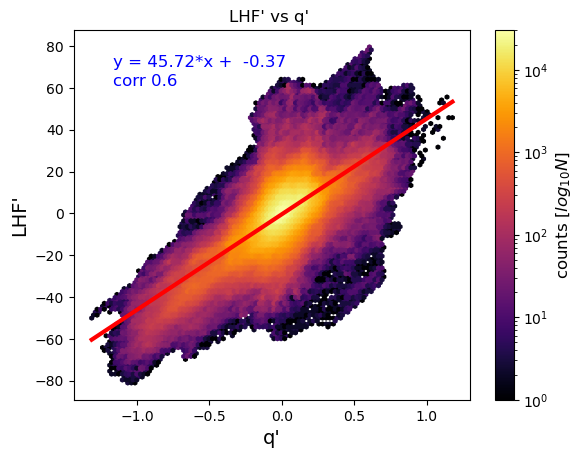

In [35]:
x = ds_in_use['sst_prime'].values
y = ds_in_use['lhf_prime'].values

tt = "LHF' vs sst' "
xlb = "sst'"
ylb = "LHF'"

linreg, corr_coeff, p_value, p_value_cannelli, sigmas = slopes_r_p_mix(x, y, nt, nskip)
fig = density_hexbin(x, y, plot_fit=True, fit=linreg, corcoe=corr_coeff, grdsz=100,\
                     title=tt, xlabel=xlb, ylabel=ylb, colormap='inferno', pos=[0.1,0.9])

print(f'p value: {round(p_value_cannelli,4)}')

p value: 0.0


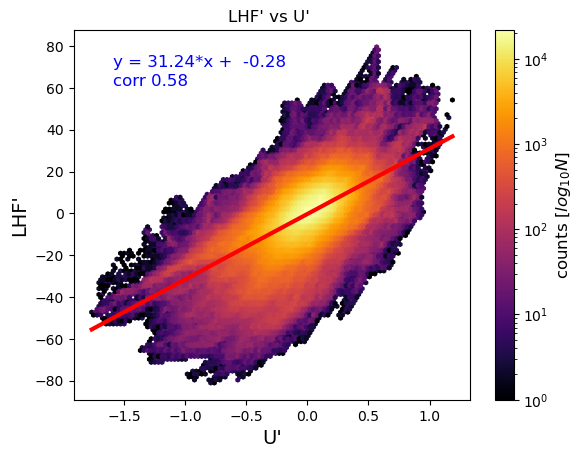

In [36]:
x = ds_in_use['U_prime'].values
y = ds_in_use['lhf_prime'].values

tt = "LHF' vs U' "
xlb = "U'"
ylb = "LHF'"

linreg, corr_coeff, p_value, p_value_cannelli, sigmas = slopes_r_p_mix(x, y, nt, nskip)
fig = density_hexbin(x, y, plot_fit=True, fit=linreg, corcoe=corr_coeff, grdsz=100,\
                     title=tt, xlabel=xlb, ylabel=ylb, colormap='inferno', pos=[0.1,0.9])

print(f'p value: {round(p_value_cannelli,4)}')

p value: 2.0


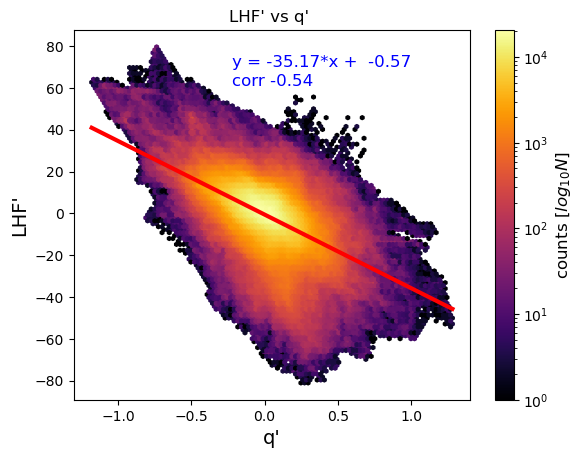

In [42]:
x = ds_in_use['qa_prime'].values*1000.
y = ds_in_use['lhf_prime'].values

tt = "LHF' vs q' "
xlb = "q'"
ylb = "LHF'"

linreg, corr_coeff, p_value, p_value_cannelli, sigmas = slopes_r_p_mix(x, y, nt, nskip)
fig = density_hexbin(x, y, plot_fit=True, fit=linreg, corcoe=corr_coeff, grdsz=100,\
                     title=tt, xlabel=xlb, ylabel=ylb, colormap='inferno', pos=[0.4,0.9])

print(f'p value: {round(p_value_cannelli,4)}')

In [50]:
beta = np.linalg.inv(X.T@X)@(X.T)@lhf_prime
beta

array([ 2.51658821e-02,  4.22754616e+01,  2.10959593e+01, -3.32132322e+01])

In [52]:
epsilon = lhf_prime - X@beta
var_eps = np.var(epsilon, ddof=3)
var_eps_corr = (epsilon.T@epsilon)/len(sst_prime-4)

unc_coeff = np.linalg.inv(primes.T@primes)*var_eps_corr

In [53]:
unc_coeff = np.sqrt(unc_coeff)
unc_coeff 

array([[0.00374664,        nan,        nan],
       [       nan, 0.00296568, 0.00130672],
       [       nan, 0.00130672, 0.00360632]])

In [55]:
 error_var_frac = (epsilon.T@epsilon)/(lhf_prime.T@lhf_prime)
error_var_frac

0.015921549506163646

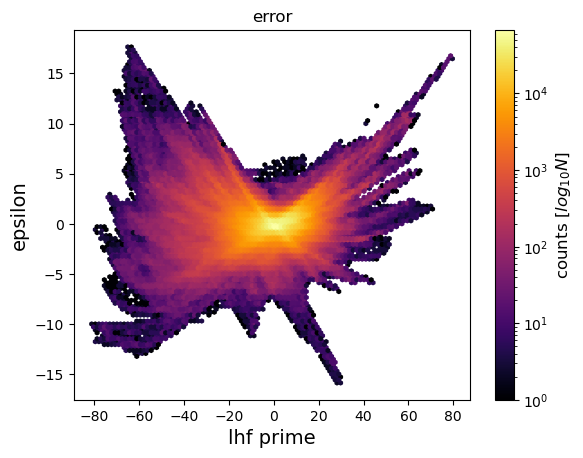

In [47]:
fig = density_hexbin(x=lhf_prime, y=epsilon, plot_fit=False, fit=None, corcoe=None, grdsz=100,\
                     title='error', xlabel='lhf prime', ylabel='epsilon', colormap='inferno', pos=[0.4,0.9])

In [8]:
# WITH 'ARTIFICIAL """""INTELIGENCE"""""'

regr_ss   = linear_model.LinearRegression(fit_intercept=False)
fit_ss = regr_ss.fit(primes_ss, lhf_prime_ss)

regr   = linear_model.LinearRegression(fit_intercept=False)
fit    = regr.fit(primes, lhf_prime)

In [14]:
if formulation == 'RH':
    print(f"coeff sst' [K] = {round(fit_ss.coef_[0], 2)}")
    print(f"coeff U' [m/s] = {round(fit_ss.coef_[1], 2)}")
    print(f"coeff T' [K] = {round(fit_ss.coef_[2], 2)}")
    print(f"coeff RH' [K] = {round(fit_ss.coef_[3], 2)}")
    print(f"score = {round(regr.score(primes, lhf_prime),2)}")

elif formulation == 'bulk':
    print(f"coeff sst' [K] = {round(fit_ss.coef_[0], 2)}")
    print(f"coeff U' [m/s] = {round(fit_ss.coef_[1], 2)}")
    print(f"coeff q' [kg/kg] = {round(fit_ss.coef_[2], 2)}")
    print(f"score = {round(regr.score(primes, lhf_prime),2)}")


coeff sst' [K] = 41.85
coeff U' [m/s] = 21.03
coeff T' [K] = -33.15
coeff RH' [K] = -697.06
score = 0.98


#### uncertainty on these coefficients

In [13]:
epsilon_ss = lhf_prime_ss - (fit_ss.predict(primes_ss))

N_notss = sst_prime.shape[0] - sst_prime_ss.shape[0]    # N_tot = N_ss + N_notss
sigma_sq = np.var(epsilon_ss, ddof=3)   #lhf_prime_ss

coeff_unc = np.linalg.inv(primes_ss.T@primes_ss)*sigma_sq
for i in range(4):
    print(round(coeff_unc[i,i]**0.5,5))

0.07041
0.0461
0.14825
1.19069


## High-pass PCA

In [56]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
X_std = StandardScaler().fit_transform(primes)

comps= int(3)
pca = PCA(n_components=comps) 

# Addestriamo il modello PCA sui dati standardizzati
vecs = pca.fit_transform(X_std)

In [57]:
vecs.shape

(5113512, 3)

In [58]:
print(pca.explained_variance_ratio_)
print(pca.singular_values_)
print(pca.components_)

[0.40554747 0.34820268 0.24624985]
[2494.25650631 2311.19359028 1943.60609923]
[[-0.55378497 -0.73837658  0.38486651]
 [ 0.61235745 -0.04795168  0.78912546]
 [ 0.56421676 -0.67268169 -0.47870532]]


<IPython.core.display.Javascript object>


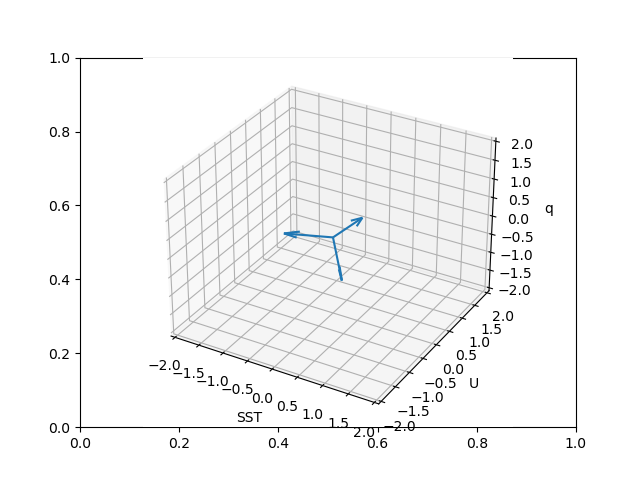

(-2.0, 2.0)

In [79]:
%matplotlib notebook

fig, ax = plt.subplots()
ax = fig.add_subplot(111, projection='3d')

u,v,w = np.empty(comps), np.empty(comps), np.empty(comps)
x, y, z = np.zeros(comps), np.zeros(comps), np.zeros(comps)

for i in range(comps):
    u[i], v[i], w[i] = pca.components_[i][0], pca.components_[i][1], pca.components_[i][2]

ax.quiver(x, y, z, u, v, w)
ax.set_xlabel('SST')
ax.set_ylabel('U')
ax.set_zlabel('q')

ax.set_xlim([-2, 2])
ax.set_ylim([-2, 2])
ax.set_zlim([-2, 2])


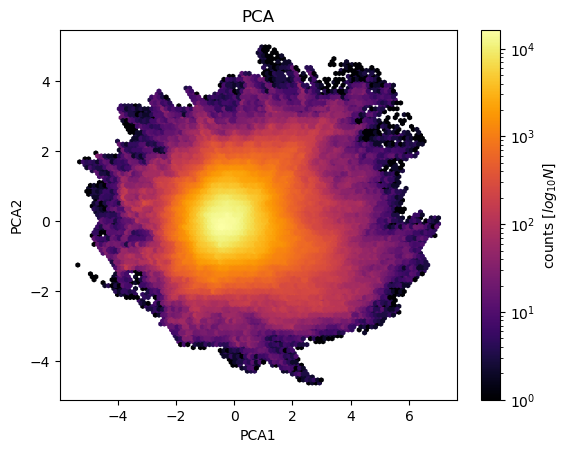

In [38]:
fig = density_hexbin(vecs[:,0],vecs[:,1],fit=None,corcoe=None,grdsz=100,title='PCA',xlabel='PCA1',ylabel='PCA2', colormap='inferno', pos=[0.1,0.9])

# let's try to fit the variance with all the terms

In [43]:
lambda_vars_ls = glob.glob('/venus/tesi_ale/data_EU/VARIANCE_LHF/daily/FEB/ForCouComparison/lambda_vars/*')
lambda_vars_ls = sorted(lambda_vars_ls)

import re
indices = []
for i, item in enumerate(lambda_vars_ls):
    if re.search(r'lhfRH', item):
        print(f'index {i}')
        indices.append(i)

    # cleaning up which data to use
indices = np.array(indices).astype('int')
for index in sorted(indices, reverse=True):
    del lambda_vars_ls[index]
    
    
vars_highpas, vars_inf, vars_bandpas = [], [], []

for i, item in enumerate(lambda_vars_ls):
    if re.search(r'passalto', item):
        vars_highpas.append(item)
    elif re.search(r'sigma-inf', item):
        vars_inf.append(item)
    elif re.search(r'bandpass', item):
        vars_bandpas.append(item)

index 1
index 3
index 5
index 7
index 9
index 11


In [ ]:
['lambda_sst', 'lambda_U', 'lambda_ta', 'lambda_RH', 'lambda_q',
 'var_lhf', 'var_sst', 'var_U', 'var_ta', 'var_RH', 
 'covar_U_sst', 'covar_ta_sst', 'covar_RH_sst', 'covar_U_ta',
 'covar_U_RH', 'covar_ta_RH', 'covar_lhf_sst', 'covar_U_q', 'covar_q_sst', 'var_qa']

In [45]:
ds_in_use = xr.open_dataset(vars_highpas[0])


lambda_U = ds_in_use['lambda_U'].values
lambda_sst = ds_in_use['lambda_sst'].values
lambda_q = ds_in_use['lambda_q'].values

var_lhf = ds_in_use['var_lhf'].values
var_qa = ds_in_use['var_qa'].values
var_U = ds_in_use['var_U'].values
covar_U_q = ds_in_use['covar_U_q'].values

# sst terms
var_sst = ds_in_use['var_sst'].values
covar_U_sst = ds_in_use['covar_U_sst'].values
covar_q_sst = ds_in_use['covar_q_sst'].values



lambda_U = lambda_U[~np.isnan(lambda_U)].flatten()
lambda_sst = lambda_sst[~np.isnan(lambda_sst)].flatten()
lambda_q = lambda_q[~np.isnan(lambda_q)].flatten()

var_lhf = var_lhf[~np.isnan(var_lhf)].flatten()
var_qa = var_qa[~np.isnan(var_qa)].flatten()
var_U = var_U[~np.isnan(var_U)].flatten()
covar_U_q = covar_U_q[~np.isnan(covar_U_q)].flatten()

var_sst = var_sst[~np.isnan(var_sst)].flatten()
covar_U_sst = covar_U_sst[~np.isnan(covar_U_sst)].flatten()
covar_q_sst = covar_q_sst[~np.isnan(covar_q_sst)].flatten()



# sst_terms = (lambda_sst**2*var_sst + 2*lambda_sst*(lambda_U*covar_U_sst +\
#                                                                    lambda_q*covar_q_sst ))
# non_sst_terms = (lambda_U**2*var_U + lambda_q**2*var_qa + 2*lambda_q*lambda_U*covar_U_q)
# var_lhf_sum = sst_terms + non_sst_terms

In [46]:
X = np.array([var_sst, var_U, var_qa, covar_U_sst, covar_q_sst, covar_U_q]).transpose()

In [49]:
regr = linear_model.LinearRegression()
fitting = regr.fit(X, var_lhf)
print(f'R2 score for fit = {round(regr.score(X, var_lhf),2)}')

R2 score for fit = 0.92


In [50]:
print(f"coeff var_sst [K2] = {round(fitting.coef_[0], 2)}")
print(f"coeff var_U [m2/s2] = {round(fitting.coef_[1], 2)}")
print(f"coeff var_q [kg2/kg2] = {round(fitting.coef_[2], 2)}")
print(f"coeff covar_U_sst = {round(fitting.coef_[3], 2)}")
print(f"coeff covar_q_sst  = {round(fitting.coef_[4], 2)}")
print(f"coeff covar_U_q = {round(fitting.coef_[5], 2)}")

print(f"intercept = {round(fitting.intercept_, 2)} W2/m4")

coeff var_sst [K2] = 1638.89
coeff var_U [m2/s2] = 380.88
coeff var_q [kg2/kg2] = 1327493064.06
coeff covar_U_sst = 1960.33
coeff covar_q_sst  = -2414059.11
coeff covar_U_q = -1968801.47
intercept = -2.47 W2/m4


### estimate Standard Error over coefficients
from here: https://stackoverflow.com/questions/22381497/python-scikit-learn-linear-model-parameter-standard-error
https://stats.stackexchange.com/questions/405429/uncertainty-in-linear-regression-coefficients

In [61]:
N = len(var_lhf)
p = X.shape[1]+1

var_lhf_pred = fitting.predict(X)
res = var_lhf - var_lhf_pred
res_sum_of_squares = res.T @ res
sigma_sqrd = res_sum_of_squares / (N - p)   #[0, 0]


X_with_intercept = np.empty(shape=(N, p), dtype=np.float)
X_with_intercept[:, 0] = 1
X_with_intercept[:, 1:p] = X  #.values


var_beta_hat = np.linalg.inv(X_with_intercept.T @ X_with_intercept) * sigma_sqrd
for p_ in range(p):
    standard_error = var_beta_hat[p_, p_] ** 0.5
    print(f"SE(beta_hat[{p_}]): {standard_error}")

SE(beta_hat[0]): 0.03669934734935445
SE(beta_hat[1]): 0.6109827783105465
SE(beta_hat[2]): 0.3293733921311048
SE(beta_hat[3]): 555816.1535398214
SE(beta_hat[4]): 1.4860325175403253
SE(beta_hat[5]): 2197.4162076830794
SE(beta_hat[6]): 716.8051876739343


In [60]:
res_sum_of_squares

7763412867.758364

## Bandpass

In [29]:
ds_bp_primes_cou, ds_bp_primes_for = xr.open_dataset(primes_bandpas[0]), xr.open_dataset(primes_bandpas[1]) 

In [31]:
couple = True
ds_in_use = ds_bp_primes_cou if couple else ds_bp_primes_for

lhf_prime = ds_in_use['lhf_prime'].values
lhf_prime_ss  = lhf_prime[::nt, ::nskip, ::nskip].flatten();  lhf_prime_ss  = lhf_prime_ss[~np.isnan(lhf_prime_ss)]
lhf_prime = lhf_prime[~np.isnan(lhf_prime)]


sst_prime, U_prime, qa_prime = ds_in_use['sst_prime'].values, ds_in_use['U_prime'].values, ds_in_use['qa_prime'].values



### subsampled satatistics for uncertainty estimation
sst_prime_ss = sst_prime[::nt, ::nskip, ::nskip].flatten();     sst_prime_ss = sst_prime_ss[~np.isnan(sst_prime_ss)]
U_prime_ss   = U_prime[::nt, ::nskip, ::nskip].flatten();        U_prime_ss = U_prime_ss[~np.isnan(U_prime_ss)]
qa_prime_ss  = qa_prime[::nt, ::nskip, ::nskip].flatten();       qa_prime_ss = qa_prime_ss[~np.isnan(qa_prime_ss)]


sst_prime = sst_prime[~np.isnan(sst_prime)].flatten()
U_prime = U_prime[~np.isnan(U_prime)].flatten()
qa_prime = qa_prime[~np.isnan(qa_prime)].flatten()

primes = np.array([sst_prime, U_prime, qa_prime]).transpose()
primes_ss = np.array([sst_prime_ss, U_prime_ss, qa_prime_ss]).transpose()


In [32]:
regr = linear_model.LinearRegression(fit_intercept=False)
fitting = regr.fit(primes_ss, lhf_prime_ss)
print(f'R2 score for fit = {regr.score(primes, lhf_prime)}')

R2 score for fit = 0.9850130480847001


In [33]:
print(f"coeff sst' [K] = {round(fitting.coef_[0], 2)}")
print(f"coeff U' [m/s] = {round(fitting.coef_[1], 2)}")
print(f"coeff q' [kg/kg] = {round(fitting.coef_[2], 2)}")
print(f"intercept = {round(fitting.intercept_, 2)} W/m2")

coeff sst' [K] = 42.28
coeff U' [m/s] = 21.4
coeff q' [kg/kg] = -33318.38
intercept = 0.0 W/m2


In [35]:
epsilon_ss = lhf_prime_ss - (fitting.predict(primes_ss))

N_notss = sst_prime.shape[0] - sst_prime_ss.shape[0]    # N_tot = N_ss + N_notss
sigma_sq = np.var(epsilon_ss, ddof=3)

coeff_unc = np.linalg.inv(primes_ss.T@primes_ss)*sigma_sq
for i in range(3):
    print(round(coeff_unc[i,i]**0.5,4))

0.0694
0.0356
42.3996


In [29]:
sigma_sq

0.9368290599259823